In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

In [3]:
X = digits["data"]

print(X.shape)
X

(1797, 64)


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

## Visualize

<Figure size 432x288 with 0 Axes>

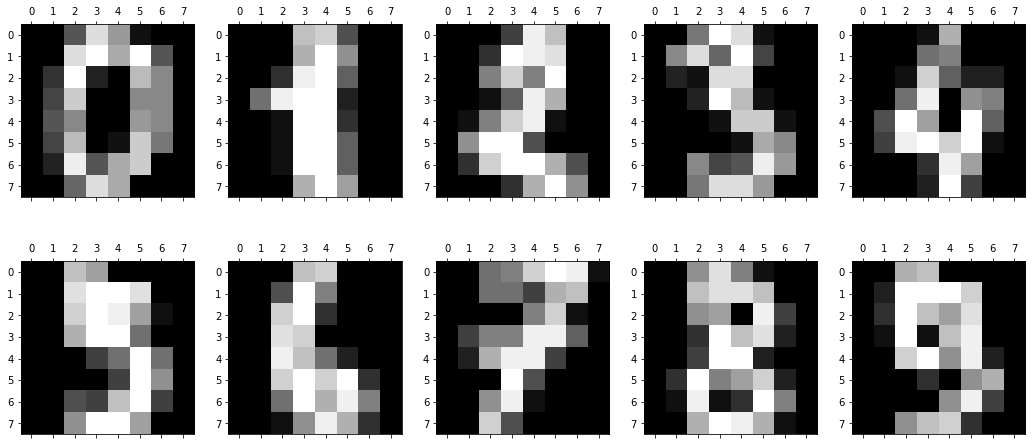

In [5]:
plt.gray()

figure, axes = plt.subplots(nrows=2, ncols=5)
figure.set_size_inches(18, 8)

axes[0][0].matshow(X[0].reshape(8, 8))
axes[0][1].matshow(X[1].reshape(8, 8))
axes[0][2].matshow(X[2].reshape(8, 8))
axes[0][3].matshow(X[3].reshape(8, 8))
axes[0][4].matshow(X[4].reshape(8, 8))
axes[1][0].matshow(X[5].reshape(8, 8))
axes[1][1].matshow(X[6].reshape(8, 8))
axes[1][2].matshow(X[7].reshape(8, 8))
axes[1][3].matshow(X[8].reshape(8, 8))
axes[1][4].matshow(X[9].reshape(8, 8))

In [6]:
y = digits["target"]

print(y.shape)
y

(1797,)


array([0, 1, 2, ..., 8, 9, 8])

## Preprocessing

In [8]:
X_mean = X.mean()

X = X - X_mean

X.mean(), X.min(), X.max()

(8.995463126623417e-17, -4.884164579855314, 11.115835420144686)

In [9]:
from keras.utils import to_categorical

y_hot = to_categorical(y)

print(y.shape, y_hot.shape)

Using TensorFlow backend.


(1797,) (1797, 10)


## Define Activation

### Sigmoid

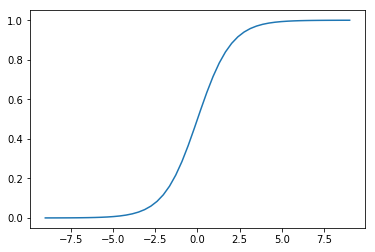

In [10]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid(xx)

plt.plot(xx, yy)

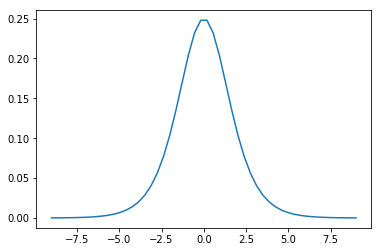

In [12]:
def sigmoid_derivative(n):
    return sigmoid(n) * (1 - sigmoid(n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid_derivative(xx)

plt.plot(xx, yy)

## Define Cross Entropy

In [13]:
def cross_entropy(actual, predict, eps=1e-5):
    actual = np.array(actual)
    predict = np.array(predict)
    
    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)
    
    loss = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    
    return -1.0 * loss.mean()

## Build a Model

In [16]:
from time import time

def train(X, y, num_epoch, learning_rate, update_method):
    history = []
    
    start = time()
    
    w1 = np.random.uniform(low=-np.sqrt(6 / (64+100)),
                          high=+np.sqrt(6 / (64+100)),
                          size=(64, 100))
    
    w2 = np.random.uniform(low=-np.sqrt(6 / (100+10)),
                          high=+np.sqrt(6 / (100+10)),
                          size=(100, 10))
    
    for epoch in range(num_epoch):
        # Forward Propagation
        z1 = X.dot(w1)
        a1 = sigmoid(z1)
        z2 = a1.dot(w2)
        a2 = sigmoid(z2)
        
        y_predict = np.argmax(a2, axis=1)
        
        accuracy = (y_predict == y).mean()
        loss = cross_entropy(a2, y_hot)
        
        if epoch % (num_epoch // 10) == 0:
            print("{:3} accuracy = {:.5f}, loss = {:.5f}".format(epoch, accuracy, loss))
            
        history.append({
            'epoch': epoch,
            'elapsed': time() - start,
            'accuracy': accuracy,
            'loss': loss,
        })
        
        # Backpropagation
        d2 = (a2 - y_hot)
        d1 = d2.dot(w2.T) * sigmoid_derivative(z1)
        
        # Weight gradients
        dw2 = a1.T.dot(d2)
        dw1 = X.T.dot(d1)
        
        w1, w2 = update_method(epoch, learning_rate, w1, w2, dw1, dw2)
        
    print("----" * 10)
    print("{0:3} accuracy = {1:.5f}, loss = {2:.5f}".format(epoch, accuracy, loss))
    
    history = pd.DataFrame(history)
    history = history[["epoch", "elapsed", "accuracy", "loss"]]

    return history

### Stochastic Gradient Descent

In [17]:
def update_sgd(epoch, learning_rate, w1, w2, dw1, dw2):
    w2 = w2 - learning_rate * dw2
    w1 = w1 - learning_rate * dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

history_sgd = train(X, y, num_epoch, learning_rate, update_method=update_sgd)
history_sgd.head()

  0 accuracy = 0.11797, loss = 5.83729
 10 accuracy = 0.84697, loss = 1.64622
 20 accuracy = 0.91764, loss = 1.30314
 30 accuracy = 0.93656, loss = 1.07263
 40 accuracy = 0.94268, loss = 0.91091
 50 accuracy = 0.94936, loss = 0.79321
 60 accuracy = 0.95437, loss = 0.70355
 70 accuracy = 0.95938, loss = 0.63301
 80 accuracy = 0.96105, loss = 0.57603
 90 accuracy = 0.96439, loss = 0.52897
----------------------------------------
 99 accuracy = 0.96939, loss = 0.49311


,epoch,elapsed,accuracy,loss
0,0,0.007369,0.117974,5.837285
1,1,0.021606,0.122983,1.646660
2,2,0.033688,0.299944,1.755301
3,3,0.043810,0.471341,1.834363
4,4,0.053753,0.607123,1.861453


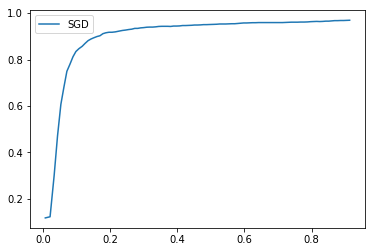

In [19]:
plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.legend()

### Momuntum

In [20]:
mu = 0.9
cache_dw1, cache_dw2 = 0, 0

def update_momentum(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + cache_dw2
    
    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + cache_dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

history_momentum = train(X, y, num_epoch, learning_rate, update_method=update_momentum)
history_momentum.head()

  0 accuracy = 0.18642, loss = 6.64647
 10 accuracy = 0.67613, loss = 1.76615
 20 accuracy = 0.90595, loss = 0.87639
 30 accuracy = 0.95381, loss = 0.46984
 40 accuracy = 0.97218, loss = 0.30209
 50 accuracy = 0.98052, loss = 0.22283
 60 accuracy = 0.98720, loss = 0.18294
 70 accuracy = 0.98887, loss = 0.15403
 80 accuracy = 0.99165, loss = 0.13526
 90 accuracy = 0.99277, loss = 0.12060
----------------------------------------
 99 accuracy = 0.99277, loss = 0.11007


,epoch,elapsed,accuracy,loss
0,0,0.004924,0.186422,6.646466
1,1,0.013260,0.135225,1.543646
2,2,0.021528,0.126322,1.225096
3,3,0.029213,0.139121,1.203155
4,4,0.036954,0.211464,1.249614


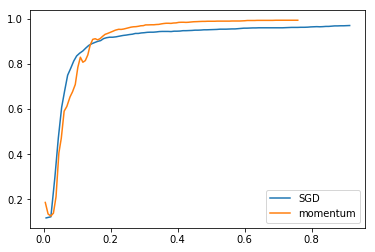

In [21]:
plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.plot(history_momentum['elapsed'], history_momentum['accuracy'], label='momentum')
plt.legend()

### Nesterov Momentum

In [24]:
mu = 0.9
cache_dw1, cache_dw2 = 0, 0

def update_nestrov(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    dw2_prew = cache_dw2
    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + (-mu * dw2_prew) + (1 + mu) * cache_dw2
    
    dw1_prew = cache_dw1
    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + (-mu * dw1_prew) + (1 + mu) * cache_dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

history_nesterov = train(X, y, num_epoch, learning_rate, update_method=update_nestrov)
history_nesterov.head()

  0 accuracy = 0.08570, loss = 5.40263
 10 accuracy = 0.83918, loss = 1.21587
 20 accuracy = 0.94602, loss = 0.57102
 30 accuracy = 0.97218, loss = 0.32933
 40 accuracy = 0.98331, loss = 0.23010
 50 accuracy = 0.98998, loss = 0.17852
 60 accuracy = 0.99332, loss = 0.14755
 70 accuracy = 0.99499, loss = 0.12727
 80 accuracy = 0.99722, loss = 0.11227
 90 accuracy = 0.99722, loss = 0.10021
----------------------------------------
 99 accuracy = 0.99777, loss = 0.09144


,epoch,elapsed,accuracy,loss
0,0,0.005420,0.085698,5.402634
1,1,0.013787,0.133556,1.396265
2,2,0.022462,0.164719,1.417629
3,3,0.030300,0.340568,1.530346
4,4,0.039113,0.545353,1.672552


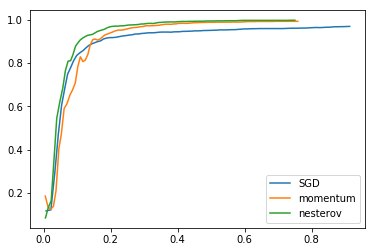

In [25]:
plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.plot(history_momentum['elapsed'], history_momentum['accuracy'], label='momentum')
plt.plot(history_nesterov['elapsed'], history_nesterov['accuracy'], label='nesterov')
plt.legend()

### AdaGrad

In [27]:
eps = 0.0000000001
cache_dw1, cache_dw2 = 0, 0

def update_adagrad(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = cache_dw2 + dw2 ** 2
    w2 = w2 - learning_rate * dw2 / np.sqrt(cache_dw2 + eps)
    
    cache_dw1 = cache_dw1 + dw1 ** 2
    w1 = w1 - learning_rate * dw1 / np.sqrt(cache_dw1 + eps)
    
    return w1, w2

num_epoch = 100
learning_rate = 0.01

history_adagrad = train(X, y, num_epoch, learning_rate, update_method=update_adagrad)
history_adagrad.head()

  0 accuracy = 0.05454, loss = 6.59779
 10 accuracy = 0.75904, loss = 2.04437
 20 accuracy = 0.89093, loss = 1.72586
 30 accuracy = 0.91263, loss = 1.54288
 40 accuracy = 0.93155, loss = 1.40721
 50 accuracy = 0.94046, loss = 1.29647
 60 accuracy = 0.94713, loss = 1.20564
 70 accuracy = 0.95159, loss = 1.12994
 80 accuracy = 0.95826, loss = 1.06521
 90 accuracy = 0.96049, loss = 1.00893
----------------------------------------
 99 accuracy = 0.96272, loss = 0.96410


,epoch,elapsed,accuracy,loss
0,0,0.005777,0.054535,6.597792
1,1,0.014290,0.126322,4.314503
2,2,0.022406,0.214246,3.400121
3,3,0.031001,0.344463,2.916097
4,4,0.039853,0.442960,2.631005


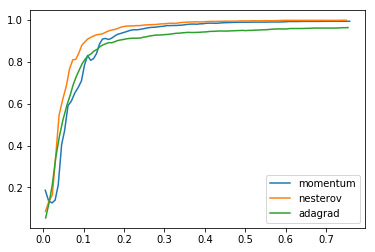

In [28]:
# plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.plot(history_momentum['elapsed'], history_momentum['accuracy'], label='momentum')
plt.plot(history_nesterov['elapsed'], history_nesterov['accuracy'], label='nesterov')
plt.plot(history_adagrad['elapsed'], history_adagrad['accuracy'], label='adagrad')
plt.legend()

### RMSProp

In [32]:
eps = 0.0000000001
decay = 0.995
cache_dw1, cache_dw2 = 0, 0

def update_rmsprop(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = decay * cache_dw2 + (1 - decay) * dw2 ** 2
    w2 = w2 - learning_rate * dw2 / np.sqrt(cache_dw2 + eps)
    
    cache_dw1 = decay * cache_dw1 + (1 - decay) * dw1 ** 2
    w1 = w1 - learning_rate * dw1 / np.sqrt(cache_dw1 + eps)
    
    return w1, w2

num_epoch = 100
learning_rate = 0.003

history_rmsprop = train(X, y, num_epoch, learning_rate, update_method=update_rmsprop)
history_rmsprop.head()

  0 accuracy = 0.13634, loss = 5.67178
 10 accuracy = 0.91263, loss = 1.28395
 20 accuracy = 0.95159, loss = 0.93052
 30 accuracy = 0.96939, loss = 0.72716
 40 accuracy = 0.97385, loss = 0.59912
 50 accuracy = 0.98108, loss = 0.50706
 60 accuracy = 0.98497, loss = 0.43822
 70 accuracy = 0.98720, loss = 0.38572
 80 accuracy = 0.98887, loss = 0.34399
 90 accuracy = 0.98998, loss = 0.31012
----------------------------------------
 99 accuracy = 0.99110, loss = 0.28504


,epoch,elapsed,accuracy,loss
0,0,0.005785,0.136338,5.671776
1,1,0.014275,0.158041,1.433359
2,2,0.022704,0.590428,1.785408
3,3,0.031297,0.751252,1.782959
4,4,0.040885,0.809126,1.645939


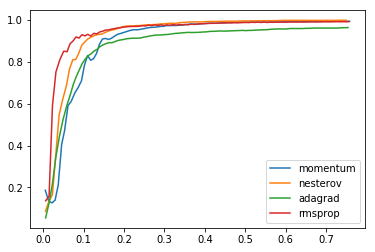

In [33]:
# plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.plot(history_momentum['elapsed'], history_momentum['accuracy'], label='momentum')
plt.plot(history_nesterov['elapsed'], history_nesterov['accuracy'], label='nesterov')
plt.plot(history_adagrad['elapsed'], history_adagrad['accuracy'], label='adagrad')
plt.plot(history_rmsprop['elapsed'], history_rmsprop['accuracy'], label='rmsprop')
plt.legend()

### Adam

In [34]:
beta1 = 0.9
beta2 = 0.99

eps = 0.000000000000001

dw1m, dw2m = 0, 0
dw1v, dw2v = 0, 0

def update_adam(epoch, learning_rate, w1, w2, dw1, dw2):
    global dw1m, dw2m
    global dw1v, dw2v
    
    dw2m = beta1 * dw2m + (1 - beta1) * dw2
    dw2v = beta2 * dw2v + (1 - beta2) * (dw2 ** 2)
    dw2mb = dw2m / (1 - beta1 ** (1 + epoch))
    dw2vb = dw2v / (1 - beta2 ** (1 + epoch))
    w2 = w2 - learning_rate * dw2mb / np.sqrt(dw2vb + eps)
    
    dw1m = beta1 * dw1m + (1 - beta1) * dw1
    dw1v = beta2 * dw1v + (1 - beta2) * (dw1 ** 2)
    dw1mb = dw1m / (1 - beta1 ** (1 + epoch))
    dw1vb = dw1v / (1 - beta2 ** (1 + epoch))
    w1 = w1 - learning_rate * dw1mb / np.sqrt(dw1vb + eps)
    
    return w1, w2

num_epoch = 100
learning_rate = 0.01

history_adam = train(X, y, num_epoch, learning_rate, update_method=update_adam)
history_adam.head()
    
    

  0 accuracy = 0.10963, loss = 5.40555
 10 accuracy = 0.60712, loss = 1.59851
 20 accuracy = 0.86978, loss = 1.39364
 30 accuracy = 0.91096, loss = 1.09455
 40 accuracy = 0.95159, loss = 0.82170
 50 accuracy = 0.96550, loss = 0.62848
 60 accuracy = 0.97440, loss = 0.49335
 70 accuracy = 0.98164, loss = 0.39732
 80 accuracy = 0.98776, loss = 0.32883
 90 accuracy = 0.99054, loss = 0.27709
----------------------------------------
 99 accuracy = 0.99221, loss = 0.24091


,epoch,elapsed,accuracy,loss
0,0,0.005640,0.109627,5.405545
1,1,0.014293,0.128548,3.646759
2,2,0.022378,0.245965,2.525924
3,3,0.030335,0.327212,1.964426
4,4,0.037946,0.463550,1.722340


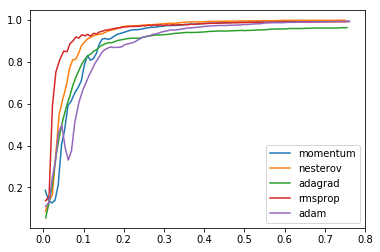

In [35]:
# plt.plot(history_sgd['elapsed'], history_sgd['accuracy'], label='SGD')
plt.plot(history_momentum['elapsed'], history_momentum['accuracy'], label='momentum')
plt.plot(history_nesterov['elapsed'], history_nesterov['accuracy'], label='nesterov')
plt.plot(history_adagrad['elapsed'], history_adagrad['accuracy'], label='adagrad')
plt.plot(history_rmsprop['elapsed'], history_rmsprop['accuracy'], label='rmsprop')
plt.plot(history_adam['elapsed'], history_adam['accuracy'], label='adam')
plt.legend()